In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy
import glob
import datetime
%matplotlib inline

# useful func
def zscore(x):
    return (x - x.mean())/x.std()

# in order to calculate distance between points using coordinates
from math import radians, cos, sin, asin, sqrt

def haversine(coords1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    
    lon1, lat1 = coords1
#     lon2, lat2 = coords2
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth 6371 for kilometers. 3956 for miles
    return c * r

# define function to calculate distance from JFK
def distFromJFK(coords):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # JFK coordinates
    latJFK = 40.6397
    lonJFK = -73.7789
    
#     return np.sqrt((lonJFK - coords[0])**2 + (latJFK - coords[1])**2)
    return haversine((lonJFK, latJFK), coords)

In [2]:
fList = glob.glob('./*.pkl')
dfList = []
distList = []
testList = ['trip_time_in_secs', 'trip_distance', 'dropoff_latitude', 'dropoff_longitude'] # list of columns to test
for idx,file in enumerate(fList):
    currDF = pd.read_pickle(file)
    currDist = currDF[['dropoff_longitude', 'dropoff_latitude']].apply(distFromJFK, axis=1)
    currDist.to_pickle('dJFK' + str(idx) + '.pkl')
    
#     # clean the data during the loading procedure to keep memory cost low
#     goodEntries = (currDF[testList] != 0).all(axis=1) &\
#     (currDF[testList] < np.inf).all(axis=1)
#     currDF = currDF[goodEntries]
#     goodEntries2 = (currDF[testList].apply(zscore) < 10).all(axis=1)
#     currDF = currDF[goodEntries2]
    dfList.append(currDF)
    distList.append(currDist)
#     if idx>0:
#         break
    
df = pd.concat(dfList)
dJFK = pd.concat(distList)

TypeError: ("haversine() missing 1 required positional argument: 'lat2'", 'occurred at index 0')

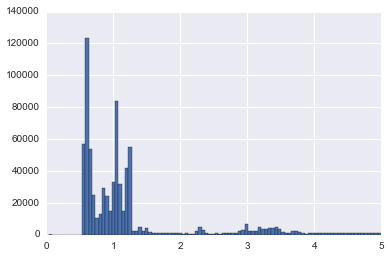

In [3]:
dJFK[dJFK<5].hist(bins=100)

In [35]:
tripsToAirport = dJFK < 2
dfAirport = df[tripsToAirport]

In [53]:
dateDur = dfAirport[['pickup_date', 'trip_time_in_secs']]
dropoffTime = dateDur.apply(lambda x: np.floor((x['pickup_date'] +
                                                  datetime.timedelta(0,x['trip_time_in_secs'])).hour % 24), axis=1)
dropoffTime.head()

89      5
135     5
189    21
228    23
650    23
dtype: float64

In [56]:
print(dfAirport.ix[189,:]['pickup_date'].time())
dfAirport.ix[189,:]['trip_time_in_secs']/60

21:01:00


19.0

In [68]:
day = np.arange(0,5)
hour = 19
location = (-74,40.74)
distFromLoc = dfAirport[['pickup_longitude', 'pickup_latitude']].apply(haversine, args=location, axis=1)
tripTimes = dfAirport['trip_time_in_secs'][(dfAirport['pickup_day_of_week'].isin(day)) &\
                                           (dropoffTime == hour) &\
                                          (distFromLoc < 0.3)]

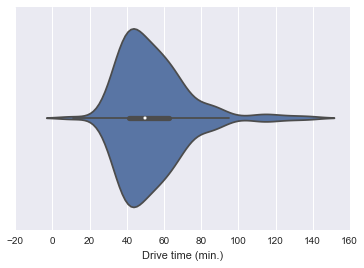

In [69]:
sns.violinplot(tripTimes/60)
plt.xlabel('Drive time (min.)')

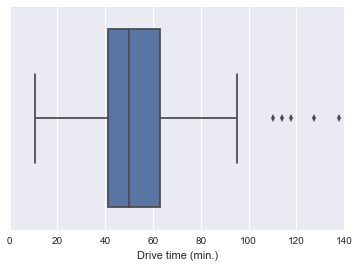

In [70]:
sns.boxplot(tripTimes/60)
plt.xlabel('Drive time (min.)')

In [30]:
df.head()

,pickup_date,pickup_day_of_year,pickup_day_of_Month,pickup_day_of_week,pickup_month,pickup_hour,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,2013-07-01 01:47:00,182,1,0,7,1,1,300,1.169922,-74.013229,40.714718,-74.003494,40.725285
1,2013-07-01 01:39:00,182,1,0,7,1,1,780,4.171875,-73.980865,40.763947,-73.933884,40.767677
2,2013-07-01 01:36:00,182,1,0,7,1,1,840,2.980469,-74.007568,40.740898,-73.980118,40.713985
3,2013-07-01 01:53:00,182,1,0,7,1,1,240,0.750000,-73.985466,40.718342,-73.982841,40.727016
4,2013-07-01 01:47:00,182,1,0,7,1,1,720,1.759766,-74.005630,40.726448,-74.003906,40.742031
